# Midterm Project - Wikipedia Movies

In [1]:
import re
import nltk
import time
import spacy
import string
import gensim
import random
import multiprocessing
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from collections import Counter
from collections import defaultdict 
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.manifold import TSNE
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, Doc2Vec
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.phrases import Phrases
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument

# For easier visualisation of labels on x-axis and y-axis
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

In [2]:
from IPython.core.display import HTML

def multi_table(table_list): #to display two or more dataframes side by side
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) + '</tr></table>')

# Data and Preprocessing
The dataset is made up by plot summary descriptions scraped from Wikipedia. It contains descriptions of 13,809 movies from around the world between 1980 and 2017. The dataset is structured as:
* `Release Year` : the year the movie has been released to the public
* `Title` : the title of the movie
* `Origin/Ethnicity` : where the movie has been produced _('American','Bollywood','British', 'Russian', 'Chinese','Hong Kong','Japanese', 'South_Korean')_
* `Director` : who directed the movie
* `Cast` : the cast involved
* `Genre` : the genre of the movie
* `Wiki Page` : the respective Wikipedia page
* `Plot` : the corresponding plot

In [3]:
df_movies = pd.read_csv('data_wiki_movies.csv')
df_movies

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1980,Airplane!,American,"Jim Abrahams, Jerry Zucker","Robert Hays, Julie Hagerty, Leslie Nielsen, Pe...",unknown,https://en.wikipedia.org/wiki/Airplane!,"As a parody film, Airplane! tells its story in..."
1,1980,Alien Dead,American,Fred Olen Ray,Buster Crabbe,unknown,https://en.wikipedia.org/wiki/Alien_Dead,A meteor strikes a houseboat in the swamps nea...
2,1980,Alligator,American,Lewis Teague,"Robert Forster, Robin Riker",unknown,https://en.wikipedia.org/wiki/Alligator_(film),A teenage girl purchases a baby American allig...
3,1980,Altered States,American,Ken Russell,"William Hurt, Blair Brown",unknown,https://en.wikipedia.org/wiki/Altered_States,"Edward Jessup is an abnormal psychologist who,..."
4,1980,American Gigolo,American,Paul Schrader,"Richard Gere, Lauren Hutton, Héctor Elizondo",unknown,https://en.wikipedia.org/wiki/American_Gigolo,"Julian Kaye is a male escort in Los Angeles, w..."
...,...,...,...,...,...,...,...,...
13804,2017,The Swindlers,South_Korean,Jang Chang-won,"Hyun Bin, Yoo Ji-tae, Bae Seong-woo, Park Sung...",unknown,https://en.wikipedia.org/wiki/The_Swindlers_(2...,A con artist who had been reported dead after ...
13805,2017,Forgotten,South_Korean,Jang Hang-jun,"Kang Ha-neul, Kim Mu-yeol, Moon Sung-keun, Na ...",unknown,https://en.wikipedia.org/wiki/Forgotten_(2017_...,A man loses his memory after being kidnapped f...
13806,2017,Steel Rain,South_Korean,Yang Woo-suk,"Jung Woo-sung, Kwak Do-won",unknown,https://en.wikipedia.org/wiki/Steel_Rain,A former agent from the North Korean intellige...
13807,2017,Along With the Gods: The Two Worlds,South_Korean,Kim Yong-hwa,"Ha Jung-woo, Cha Tae-hyun, Kim Hyang-gi, Lee J...",unknown,https://en.wikipedia.org/wiki/Along_With_the_G...,Story of the death of an ordinary fireman name...


A quick representation of the number of movies released per origin throughout the years between 1980-2017.

Text(0.5, 1.0, 'Total number of movies released per ethnicity between 1980-2017')

<Figure size 720x360 with 0 Axes>

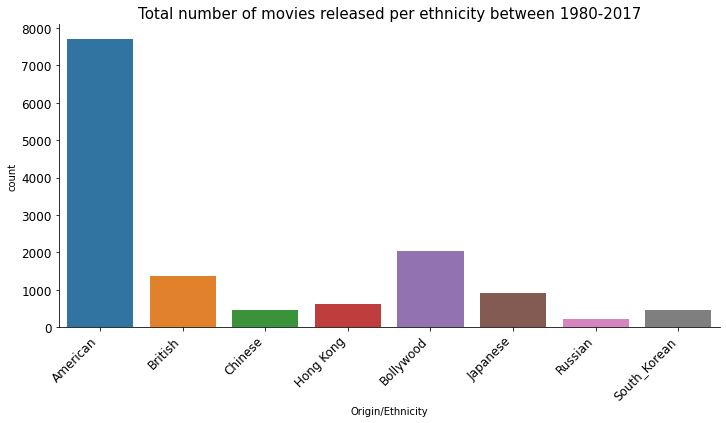

In [4]:
plt.figure(figsize=(10,5))
sns.catplot(x = "Origin/Ethnicity", kind="count", data= df_movies, height=5, aspect=2)
plt.xticks(rotation=45, 
    horizontalalignment='right')
plt.title("Total number of movies released per ethnicity between 1980-2017", fontsize=15)

Here we can observe the movie release distribution per country. The USA were the most productive, having their peak in 2006 and 2013. Second to them is Bollywood and the British industry.

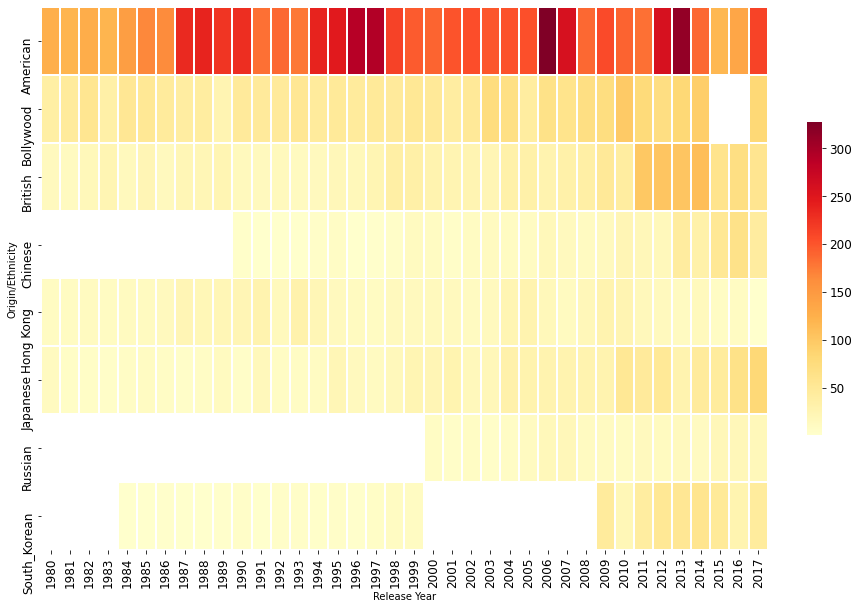

In [5]:
country_year = df_movies.groupby(["Origin/Ethnicity","Release Year"]).size().unstack()

plt.figure(figsize=(14,10))
g = sns.heatmap(
    country_year, 
    cbar_kws={'fraction' : 0.02}, # shrink colour bar
    cmap='YlOrRd', 
    linewidth=1 # space between cells
)

In [6]:
# Cleaning the dataset and keeping values of interest
data = df_movies.drop(['Director', 'Cast', 'Genre', 'Wiki Page'], axis = 1)

#dropping Russian movies since they do not contribute much to the overall dataset and it is not one of the variables of interest
data = data[(data['Origin/Ethnicity'] != 'Russian')] 
data['Origin/Ethnicity'].replace({'Hong Kong': 'Hong_Kong'}, inplace=True)
data = data.rename({'Origin/Ethnicity' : 'Origin'}, axis = 1)

# Checking whether there are missing values in 'Plot'
data['Plot'].isna().sum()

0

Here I am preferring lemmatization to stemming, since I am interested in the words employed in the plots and I do not want to delete too much noise.

In [7]:
# Preprocessing 'Plots' for Topic Models
nlp = spacy.load('en_core_web_sm')

def preprocess_tm(text): #I am not turning everything to lower case as I need it to get rid of proper names
    lemmas = [token.lemma_ for token in nlp(text) if token.pos_ in \
              {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}] # only content words (no need for PROPN)

    return ' '.join(lemmas)


# Function will preprocess all the Plots (tokenization + lemmatization)
def preprocess(text):
    text = text.lower() # turn all the text to lower cases
    lemmas = [token.lemma_ for token in nlp(text) ]
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in STOP_WORDS] # lemma is alphabetic only and not a stop word 
                                                            # (I wanted to focus on getting pure text))
    return a_lemmas

**NB**. The `preprocess` function will be utilised during the analysis phase following `preprocess_tm`, as it would then further clean the text and prepare it for tools like _word2vec_  and _doc2vec_.

In [8]:
# Applying preprocess_tm to clean the data from 'Plots' and creating a new column 'Plot_cleaned'
data['Plot_cleaned'] = data['Plot'].apply(lambda x: preprocess_tm(x)) # cleaned Plots

# To save the dataset into a .csv file
np.savez_compressed('data_clean')
data.to_csv('data_cleaned.csv', index = False)

In [9]:
# To save time I have saved the entire dataset preprocessed and cleaned. Hence, refer to this for the analysis onwards
data_clean = pd.read_csv('data_cleaned.csv')
data_clean

,Release Year,Title,Origin,Plot,Plot_cleaned
0,1980,Airplane!,American,"As a parody film, Airplane! tells its story in...",parody film tell story intermix several cut sc...
1,1980,Alien Dead,American,A meteor strikes a houseboat in the swamps nea...,meteor strike houseboat swamp southern town ca...
2,1980,Alligator,American,A teenage girl purchases a baby American allig...,teenage girl purchase baby american alligator ...
3,1980,Altered States,American,"Edward Jessup is an abnormal psychologist who,...",abnormal psychologist study schizophrenia begi...
4,1980,American Gigolo,American,"Julian Kaye is a male escort in Los Angeles, w...",male escort job support require expensive tast...
...,...,...,...,...,...
13572,2017,The Swindlers,South_Korean,A con artist who had been reported dead after ...,con artist report dead commit grand fraud case...
13573,2017,Forgotten,South_Korean,A man loses his memory after being kidnapped f...,man lose memory kidnap day young brother deter...
13574,2017,Steel Rain,South_Korean,A former agent from the North Korean intellige...,former agent north korean intelligence senior ...
13575,2017,Along With the Gods: The Two Worlds,South_Korean,Story of the death of an ordinary fireman name...,story death ordinary fireman name head grim re...


### Statistics: Before & After Preprocessing

In [10]:
print('BEFORE PREPROCESSING')
print('Number of documents: ', len(df_movies))
print('Number of columns: ', len(list(df_movies.columns)))
countries_before = set(list(df_movies['Origin/Ethnicity'])) 
print('Number of countries: ', len(countries_before))
tokens_before = " ".join(df_movies['Plot'].to_list()).split()
print('Number of tokens: ', len(tokens_before))
print('List of columns: ', list(df_movies.columns))
print('List of countries:', countries_before)

BEFORE PREPROCESSING
Number of documents:  13809
Number of columns:  8
Number of countries:  8
Number of tokens:  6600681
List of columns:  ['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot']
List of countries: {'Russian', 'South_Korean', 'Chinese', 'Hong Kong', 'American', 'Bollywood', 'British', 'Japanese'}


In [11]:
print('AFTER PREPROCESSING')
print('Number of documents: ', len(data_clean))
print('Number of columns: ', len(list(data_clean.columns)))
countries_after = set(list(data_clean['Origin'])) 
print('Number of countries: ', len(countries_after))
tokens_after = " ".join(data_clean['Plot_cleaned'].to_list()).split()
print('Number of tokens: ', len(tokens_after))
print('List of columns: ', list(data_clean.columns))
print('List of countries:', countries_after)

AFTER PREPROCESSING
Number of documents:  13577
Number of columns:  5
Number of countries:  7
Number of tokens:  2823040
List of columns:  ['Release Year', 'Title', 'Origin', 'Plot', 'Plot_cleaned']
List of countries: {'South_Korean', 'Chinese', 'American', 'Bollywood', 'Hong_Kong', 'British', 'Japanese'}


Text(0.5, 1.0, 'Word distribution in Plots after')

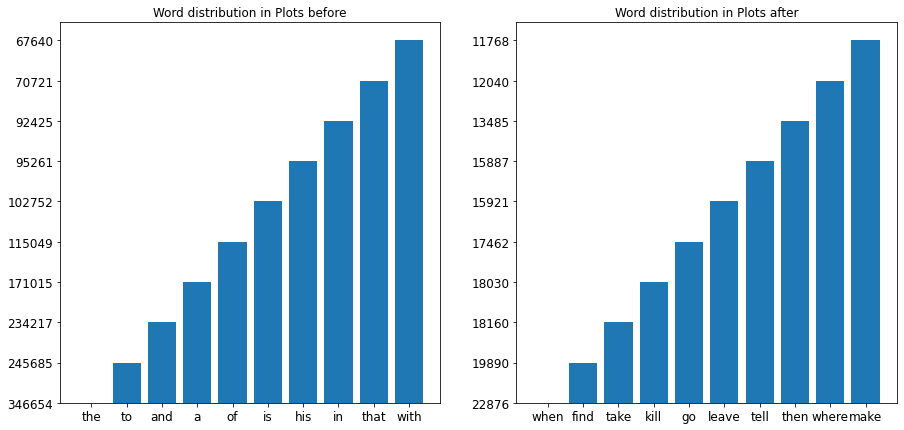

In [12]:
# Plotting the difference between before and after preprocessing in the Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
before = np.array(Counter(" ".join(list(filter(lambda x: isinstance(x, str), list(data_clean['Plot'])))).split()).most_common(10))
after = np.array(Counter(" ".join(list(filter(lambda x: isinstance(x, str), list(data_clean['Plot_cleaned'])))).split()).most_common(10))

ax[0].bar(before[:, 0], before[:, 1])
ax[0].set_title('Word distribution in Plots before')
ax[1].bar(after[:, 0], after[:, 1])
ax[1].set_title('Word distribution in Plots after')

Moreover, I will be creating 4 macroregions of countries, by grouping together the Asian countries into one dataframe. 

In [13]:
USA_df = data_clean[data_clean['Origin'] == 'American']
Bollywood_df = data_clean[data_clean['Origin'] == 'Bollywood'].reset_index(drop = True)
Asia_df = data_clean[(data_clean['Origin'] == 'Chinese') | (data_clean['Origin'] == 'Japanese') |\
                    (data_clean['Origin'] == 'South_Korean')|(data_clean['Origin'] == 'Hong_Kong')].reset_index(drop = True)
UK_df = data_clean[data_clean['Origin'] == 'British'].reset_index(drop = True)

print('SUB-DATAFRAMES STATISTICS')
print("USA's number of documents: ", '     ', len(USA_df))
print("Bollywood's number of documents: ", len(Bollywood_df))
print("Asia's number of documents:  ", '   ', len(Asia_df))
print("UK's number of documents:      ",' ', len(UK_df))
print('---------------------------------------------')
print("Total number of documents:     ", '', len(data_clean))

SUB-DATAFRAMES STATISTICS
USA's number of documents:        7707
Bollywood's number of documents:  2027
Asia's number of documents:       2472
UK's number of documents:         1371
---------------------------------------------
Total number of documents:       13577


# ANALYSIS
In this Notebook I will be analysing:
* How the same word 'war' is positioned among Asian countries, USA, Britain, and Bollywood's plots (Word2vec)
* How similar are the plots of one country to the other ones (Doc2vec)
* Finding movie similarity through cosine similarity (TFIDF)
* Finding the main topics narrated by each country's movie plots (Topic Models)
* Based on all countries' plots, how would a plot continue from a random sentence (Language Models)

NB. Each visualisation will be immediately after the respective analysis

## 1 ) Word Embedding with Word2Vec
Analysing how the same word _'war'_ is used in Asian countries, British, USA, and Bollywood. I am relying on word2vec since there is a consistent amount of words in the corpus (which will create better word vectors) and I will iterate  it for each macro group to see their words' similarity with _'war'_.

In [14]:
def w2v_model(dataframe, min_count): # since the corpuses of ≠ countries' movies might be very different, 
                                     # I need ≠ minimum counts for word2vec (especially for the tsne function below)
    corpus = []
    for i in dataframe:
        corpus.append(preprocess(i)) #preprocessing in list of lists
    
    w2v_model = Word2Vec(size=100, # vector size
                     window=15, # window for sampling
                     sample=0.0001, # subsampling rate
                     iter=200, # iterations
                     negative=5, # negative samples
                     min_count= min_count, 
                     workers=-1, # parallelize to all cores
                     hs=0, # no hierarchical softmax
                     seed = 1) 
    
    w2v_model.build_vocab(corpus) #building vocabulary
    
    w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs) #training the model
    
    model = w2v_model.wv
    return model

In [15]:
# The most similar words to "war" in the Asian plots
most_similar_asia = w2v_model(Asia_df['Plot_cleaned'], 5).most_similar('war') # minimum threshold set to 5 to 
                                                                              # avoid too rare words
# The most similar words to "war" in the Bollywood plots
most_similar_bolly = w2v_model(Bollywood_df['Plot_cleaned'], 5).most_similar('war')

# The most similar words to "war" in the American plots
most_similar_usa = w2v_model(USA_df['Plot_cleaned'], 5).most_similar('war')

# The most similar words to "war" in the British plots
most_similar_uk = w2v_model(UK_df['Plot_cleaned'], 5).most_similar('war')

In [16]:
# Printing the results
print('############ Most similar words to "war" in Asian Plots ############')
print('')
print(pd.DataFrame(most_similar_asia, columns = ['word', 'values']))
print('')
print('############ Most similar words to "war" in Bollywood Plots ############')
print('')
print(pd.DataFrame(most_similar_bolly, columns = ['word', 'values']))
print('')
print('############ Most similar words to "war" in American Plots ############')
print('')
print(pd.DataFrame(most_similar_usa, columns = ['word', 'values']))
print('')
print('############ Most similar words to "war" in British Plots ############')
print('')
print(pd.DataFrame(most_similar_uk, columns = ['word', 'values']))
print('')

############ Most similar words to "war" in Asian Plots ############

        word    values
0      youth  0.383802
1     evolve  0.351868
2    advance  0.346595
3    useless  0.344526
4    fulfill  0.313366
5  unwelcome  0.311437
6        leg  0.305559
7     subtle  0.304500
8       warn  0.298573
9        gun  0.297686

############ Most similar words to "war" in Bollywood Plots ############

      word    values
0    youth  0.383802
1    suave  0.358680
2   evolve  0.351868
3  advance  0.346595
4  useless  0.344526
5  fulfill  0.313366
6      leg  0.305559
7   subtle  0.304500
8     warn  0.298573
9      gun  0.297686

############ Most similar words to "war" in American Plots ############

         word    values
0       youth  0.383802
1    outright  0.361957
2       suave  0.358680
3      pilfer  0.357303
4      evolve  0.351868
5     advance  0.346595
6     useless  0.344526
7   collusion  0.324405
8  homecoming  0.323161
9     fulfill  0.313366

############ Most similar words 

Sadly, _'youth'_ is the most similar word based on word2vec to _'war'_. Across origins, the words are quite similar among each other and reflect the real meaning of the chosen word.

## 1.1) Visualisation: word2vec 
Display the most similar words to _"war"_ by leveraging on TSNE in two dimensions.

In [17]:
def plot_closestwords(model,word, title):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.most_similar(word_labels)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # scatter plot
    plt.figure(figsize=(6,6))
    plt.scatter(x_coords, y_coords)
    plt.rcParams.update({'font.size': 10})
    plt.title(title)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

For reference: https://gist.github.com/aneesha/da9216fb8d84245f7af6edaa14f4efa9 (`plot_closestwords`)

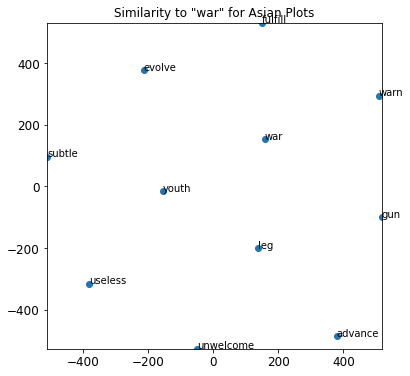

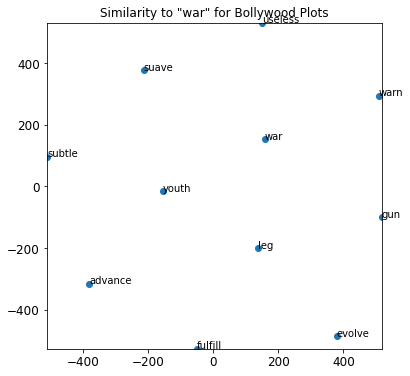

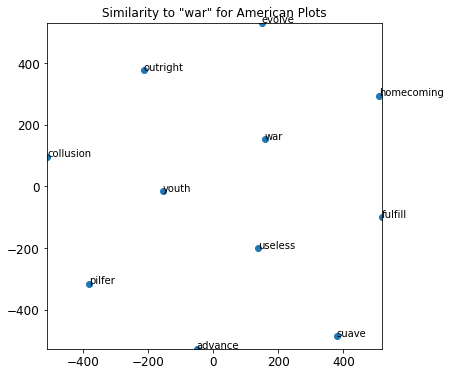

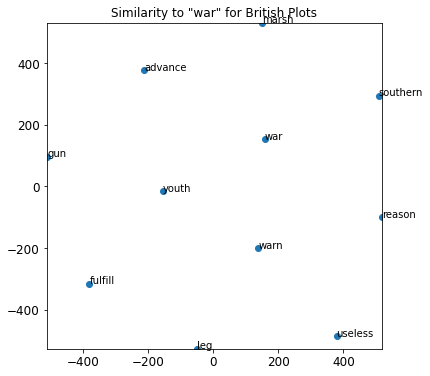

In [18]:
# Visualisation for Asian movies
plot_closestwords(w2v_model(Asia_df['Plot_cleaned'], 5), 'war','Similarity to "war" for Asian Plots')

# Visualisation for Bollywood movies
plot_closestwords(w2v_model(Bollywood_df['Plot_cleaned'], 5), 'war','Similarity to "war" for Bollywood Plots')

# Visualisation for American movies
plot_closestwords(w2v_model(USA_df['Plot_cleaned'], 5), 'war', 'Similarity to "war" for American Plots')

# Visualisation for British movies
plot_closestwords(w2v_model(UK_df['Plot_cleaned'], 5), 'war', 'Similarity to "war" for British Plots')

### Dimensionality reduction using t-SNE (2D) and word2vec 
Visualisation of how words in each sub dataset is distributed. In the previous section, I was focusing primarily on the similarity with the word _"war"_. Here I will be investigating the distribution of the overall words in plots for two arbitrary origins: Asian and American.

In [19]:
# Creates a TSNE model and plots it
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word]) #creating token list
        labels.append(word) #creating the list of labels for each token
    
    # I am keeping two dimensions for visualisation purposes (since the dimensionality is quite high)
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23) 
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

<ipython-input-19-a9822d49e4fc>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  for word in model.wv.vocab:


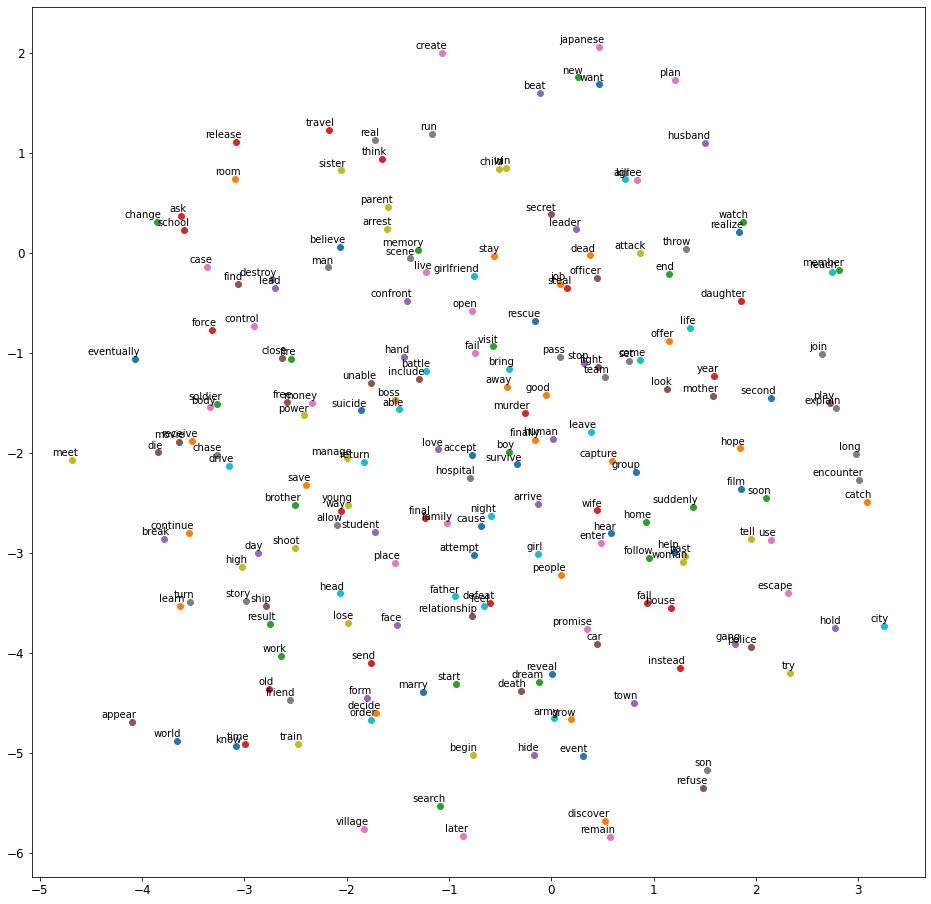

In [20]:
# Visualise how the the words in Asian plots are distributed 
asia_tsne = w2v_model(Asia_df['Plot_cleaned'], 300) 

tsne_plot(asia_tsne)

<ipython-input-19-a9822d49e4fc>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  for word in model.wv.vocab:


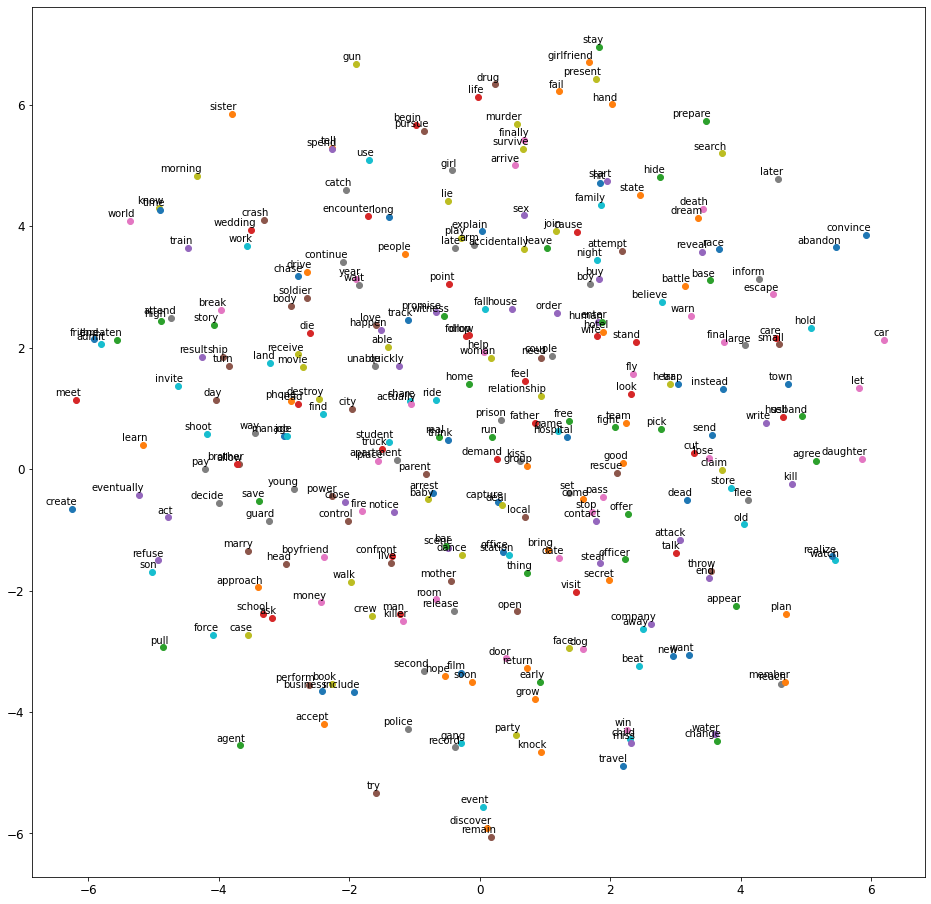

In [21]:
# Visualise how the the words in American plots are distributed 
usa_tsne = w2v_model(USA_df['Plot_cleaned'], 1000) # minimum count set to 1000, otherwise the graph would be too dense
tsne_plot(usa_tsne)

## 2) Document Embedding with Doc2Vec
Analysing the similarity among plots from all countries in the dataset ( here I am considering China, Japan, South Korean, and Hong Kong separately as I would like to see their individual similarities). I am using doc2vec as I am treating each origin as a document ( containing all their respective plots). 

In [22]:
#I want to see the similarity between plots for all the countries in the dataset
df_all = data_clean[["Origin",'Plot_cleaned']] 

# create a list of TaggedDocument objects
corpus = []

for label, text in zip(df_all['Origin'], df_all.Plot_cleaned):
    corpus.append(TaggedDocument(words=text.split(), 
                                 tags=[str(label)]))

# initialize model
d2v_model = Doc2Vec(vector_size=100, 
                    window=15,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [23]:
#Finding the most similar countries based on plots
origins = ['Chinese', 'Japanese', 'South_Korean','Hong_Kong', 'British', 'American', 'Bollywood']

def similar_doc(origin):
    similar_docs = d2v_model.docvecs.most_similar(origin)
    return similar_docs

l = []
for i in origins:
    df = pd.DataFrame(similar_doc(i), columns=['country', 'value']).style.set_caption(f'Most Similar to {i} Plots')
    l.append(df)
    
multi_table(l)

,country,value
0,Hong_Kong,0.016405
1,Bollywood,0.004586
2,American,0.001627
3,British,-0.063288
4,Japanese,-0.108030
5,South_Korean,-0.224023
,country,value
0,American,0.292812
1,Hong_Kong,0.210911
2,South_Korean,0.137266


From each table we can observe the similarity among each country's plots with the others' from the dataset

## 2.1) Visualisation: doc2vec
Seeing which countries are similar to which based on plots

In [24]:
def plot_vectors(vectors, indexes, title='Visualisation', labels=None, dimensions=3):
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if given
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('autumn') # color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
        for label, x, y, z in zip(indexes, vectors[:, 0], vectors[:, 1],  vectors[:, 2]):
            ax.text(x, y, z, label)
    
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
    else:
        raise NotImplementedError()
    
    plt.title(title)
    plt.show()

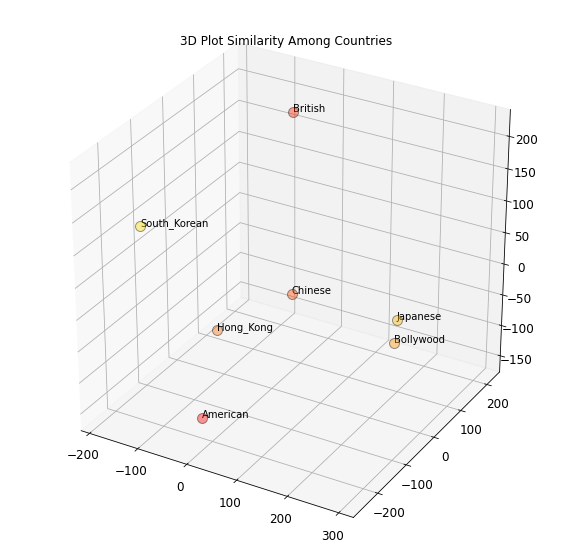

In [25]:
from matplotlib import colors

# Creating variables
doc_tags = list(d2v_model.docvecs.doctags.keys())
X_model = d2v_model[doc_tags]
tsne = TSNE(n_components = 3)
X_tsne = tsne.fit_transform(X_model)
df_tsne = pd.DataFrame(X_tsne, index = doc_tags, columns = ['x','y','z'])

# Plotting in 3D
plot_vectors(df_tsne.to_numpy(), df_tsne.index, '3D Plot Similarity Among Countries', df_tsne.index, dimensions = 3)

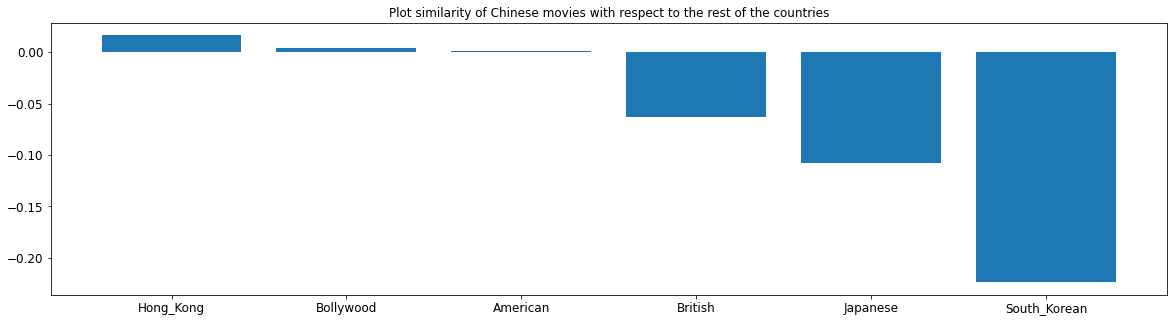

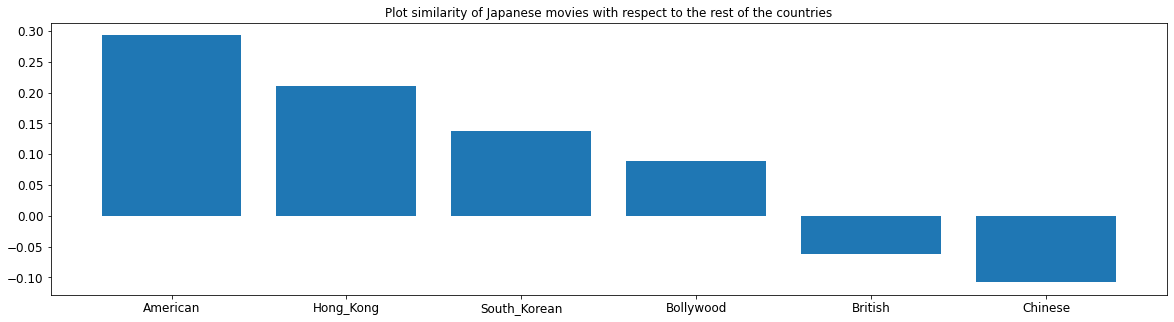

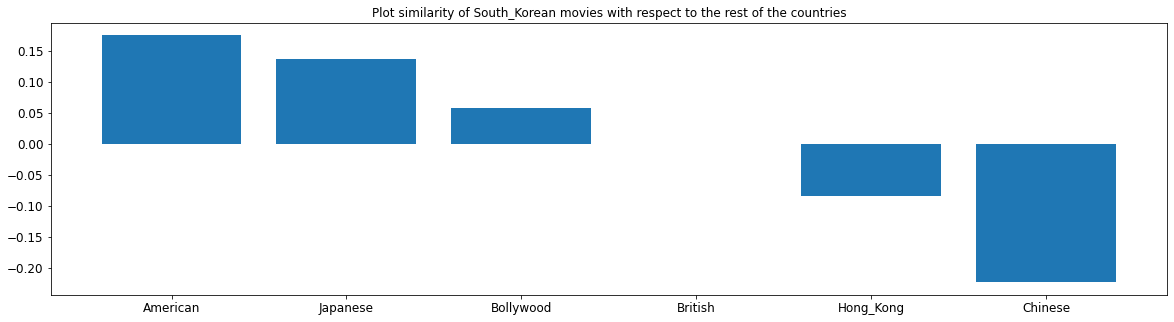

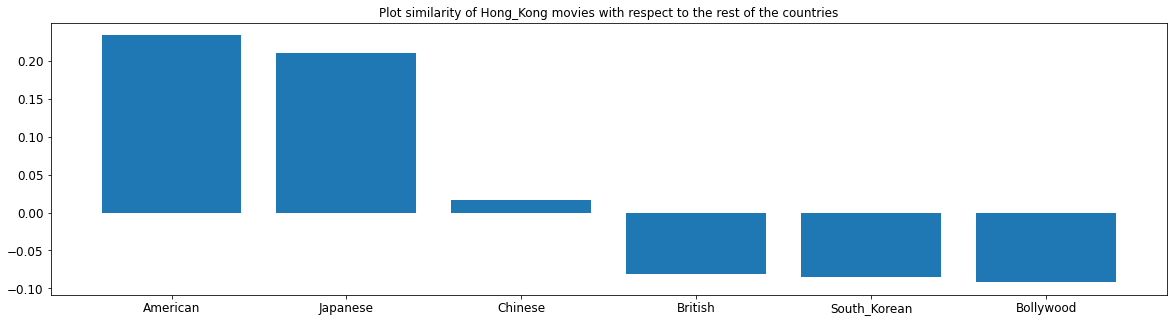

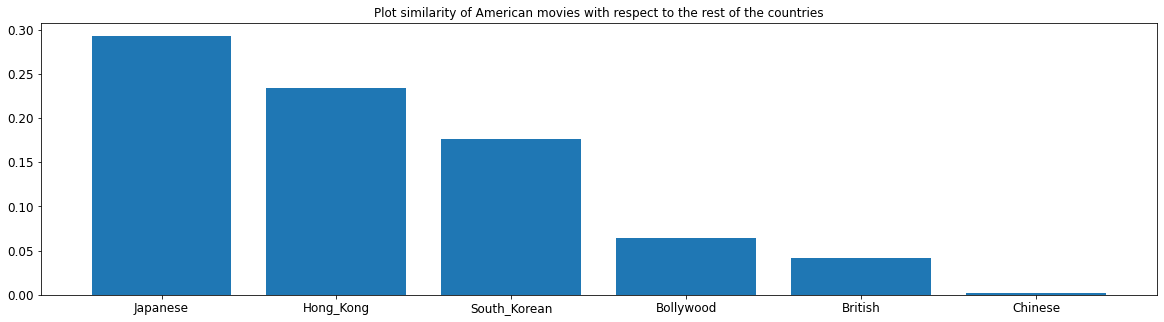

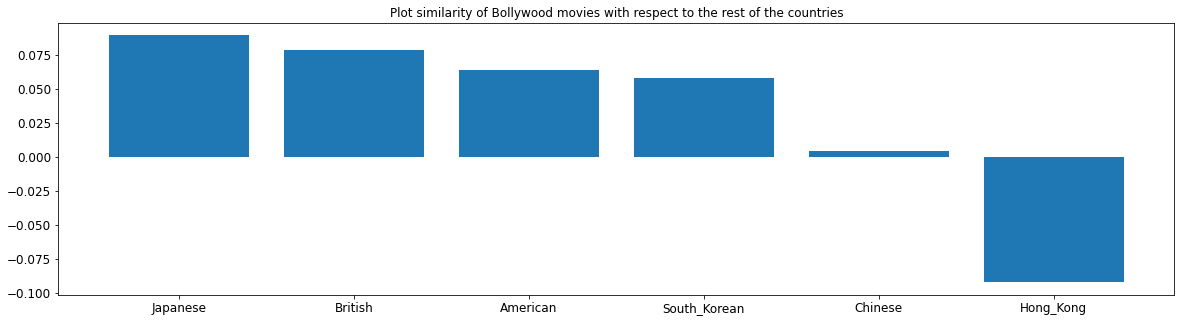

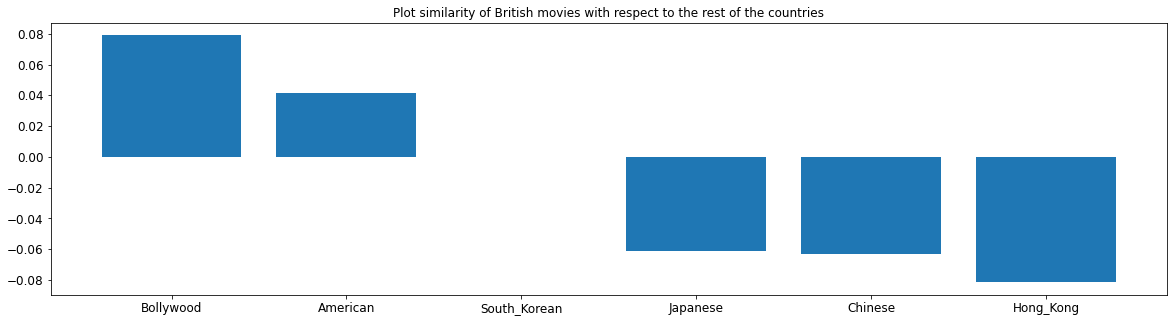

In [26]:
# A visualisation through histograms
countries = ['Chinese', 'Japanese', 'South_Korean', 'Hong_Kong', 'American', 'Bollywood', 'British']

for j in countries:
    similarity_values = []
    labels = []
    similar = np.array(pd.DataFrame(similar_doc(j)))
    for i in similar:
        similarity_values.append(i[1])
        labels.append(i[0])
        
    plt.figure(figsize=(20,5))
    plt.bar(labels, similarity_values, align='center')
    plt.xticks(list(range(6)), labels)
    plt.title(f"Plot similarity of {j} movies with respect to the rest of the countries" )
    plt.show() 

## 3) TF-IDF
Movie similarity based on plot by applying cosine similarity. I am using TF-IDF as I want to classify their similarity based on the weight of importance each document has on the entire corpus. 

In [27]:
test = data_clean[['Title', 'Plot_cleaned']]
test

,Title,Plot_cleaned
0,Airplane!,parody film tell story intermix several cut sc...
1,Alien Dead,meteor strike houseboat swamp southern town ca...
2,Alligator,teenage girl purchase baby american alligator ...
3,Altered States,abnormal psychologist study schizophrenia begi...
4,American Gigolo,male escort job support require expensive tast...
...,...,...
13572,The Swindlers,con artist report dead commit grand fraud case...
13573,Forgotten,man lose memory kidnap day young brother deter...
13574,Steel Rain,former agent north korean intelligence senior ...
13575,Along With the Gods: The Two Worlds,story death ordinary fireman name head grim re...


In [28]:
# TFIDF 
lemma_plot = []
for i in test['Plot_cleaned']:
    lemma_plot.append(i) #creating a list of plots
    
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(lemma_plot)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(test.index, index=test['Title']).drop_duplicates() #getting the index for each film 

# Cosine similarity 
def cosine_recommendations(title, cosine_sim, indices): #'title' is the movie we want to find similarity to
    idx = indices[title]
    similarity = list(enumerate(cosine_sim[idx])) #listing all the indeced and their cosine similarities to 'title' 
    similarity = sorted(similarity, key = lambda x: x[1], reverse = True)
    similarity = similarity[1:10] #considering the top 9 (since similary[0] is out title)
    movies_idx = [i[0] for i in similarity] #getting the index of title
    return test['Title'].iloc[movies_idx] 

In [29]:
# printing the most similar plots to the movie chosen (in this case: 'The Hunger Games') and their respective index in data_clean 

print(cosine_recommendations('The Hunger Games', cosine_sim, indices))

6886     Catching Fire, The Hunger Games:The Hunger Gam...
7016                 Starving Games, TheThe Starving Games
12431                                        Battle Royale
7226                 The Hunger Games: Mockingjay – Part 1
7535                                  The Belko Experiment
2089                                  Beauty and the Beast
5129                                            Abominable
8506                 World of the Dead: The Zombie Diaries
11540                                            Saawariya
Name: Title, dtype: object


## 3.1 ) Visualisation: TF-IDF 
Here I will be visualising the TF-IDF distribution of the 2 most similar plots to _"The Hunger Games"_ , i.e. its parody  _"The Starving Games"_  and another similar movie _"Battle Royale"_. I am not directly considering the first most similar (_"Catching fire"_ ), since it is the sequel of the movie chosen, so it would be obvious that they would be very similar.

I am eliminating proper names (PROPN) with POS analysis as I would like to see the similarity between the actual words of the plots and not the names, since it is a given that the names will be different (although between the original film and the parody it would be fun to see how they differ, but from a TF-IDF perspective it is a given that they would be the most frequent ones).

In [30]:
def plot_cleaned(dataframe, index): #cleans the plot of our chosen movie to prepare it for tfidf analysis
    
    def preprocess_joined(text):
        lemmas = [token.lemma_ for token in nlp(text) if token.pos_ not in {'PROPN'}]
        a_lemmas = [lemma for lemma in lemmas 
                if lemma.isalpha() and lemma not in STOP_WORDS] #lemma is alphabetic only and not a stop word

        return ' '.join(a_lemmas)

    body = []
    original_plot = dataframe[index]
    new = original_plot.split(".")

    for i in new:
        body.append(preprocess_joined(i))
    
    return body

In [31]:
def tfidf_vect(body):

    tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   stop_words='english', 
                                   sublinear_tf=True)

    vectorizer = CountVectorizer(analyzer='word', 
                                 min_df=0.001, 
                                 max_df=0.75, 
                                 stop_words='english')

    X = tfidf_vectorizer.fit_transform(body)
    X2 = vectorizer.fit_transform(body)

    #Creating the dataframe containing the tfidf vectors
    df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                            'tf': X2.sum(axis=0).A1, 
                            'idf': tfidf_vectorizer.idf_,
                            'tfidf': X.sum(axis=0).A1
                       }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF
    return df

In [32]:
# Getting the dataframes of TFIDS distributions of the 3 movies
SG = tfidf_vect(plot_cleaned(data_clean['Plot'], 7016)) #Plot of Starving Games
HG = tfidf_vect(plot_cleaned(data_clean['Plot'], 6631)) #Plot of The Hunger Games
BR = tfidf_vect(plot_cleaned(data_clean['Plot'], 12431)) #Plot of Battle Royale

print('######## Hunger Games TFIDF ########') 
print(HG, '\n')
print('######## Starving Games TFIDF ########') 
print(SG, '\n')
print('######## Battle Royale TFIDF ########') 
print(BR, '\n')

######## Hunger Games TFIDF ########
          word  tf       idf     tfidf
12      annual   1  4.135494  0.286003
23         boy   1  4.135494  0.286003
68       force   1  4.135494  0.286003
77        girl   1  4.135494  0.286003
113     nation   1  4.135494  0.286003
..         ...  ..       ...       ...
129    provide   4  3.219203  1.251161
117  nightlock   3  3.442347  1.262461
186     victor   3  3.442347  1.380285
178    tribute   6  2.882731  1.599560
100       kill   4  3.219203  1.784167

[195 rows x 4 columns] 

######## Starving Games TFIDF ########
           word  tf       idf     tfidf
35       decide   1  3.740840  0.281831
63    implement   1  3.740840  0.281831
73        learn   1  3.740840  0.281831
75      lesbian   1  3.740840  0.281831
78         love   1  3.740840  0.281831
..          ...  ..       ...       ...
50         flee   3  3.047693  1.140098
123        team   4  2.824549  1.328107
30   contestant   5  2.824549  1.582136
130         try   6  2.488077 

In [33]:
# Scatterplot for visualising the 10 most common words for the three TFIDF distribution
def scatter_tfidf_10(dataframe_list, labels): 
    fig, ax = plt.subplots(figsize = (16,12))

    for plot in dataframe_list:
        plot['tf'] *= 100 # to ease visualisation in the graph

        plt.scatter(x = plot.iloc[-10:,:]['tfidf'], #getting the most frequent 10
                                y = plot.iloc[-10:,:]['idf'],
                                s = plot.iloc[-10:,:]['tf'],
                                alpha = 0.3,
                                edgecolor = 'k');

        for label, x, y in zip(plot.iloc[-10:,0], plot.iloc[-10:,3], plot.iloc[-10:,2]):
                    txt = plt.annotate(label,xy=(x, y))
    
    #setting labels for the legend
    titles = [] 
    for i in labels:
        titles.append(i)
    
    plt.legend(titles, loc='best', fontsize=16)
    plt.ylabel('idf')
    plt.xlabel('tfidf')
    plt.show()

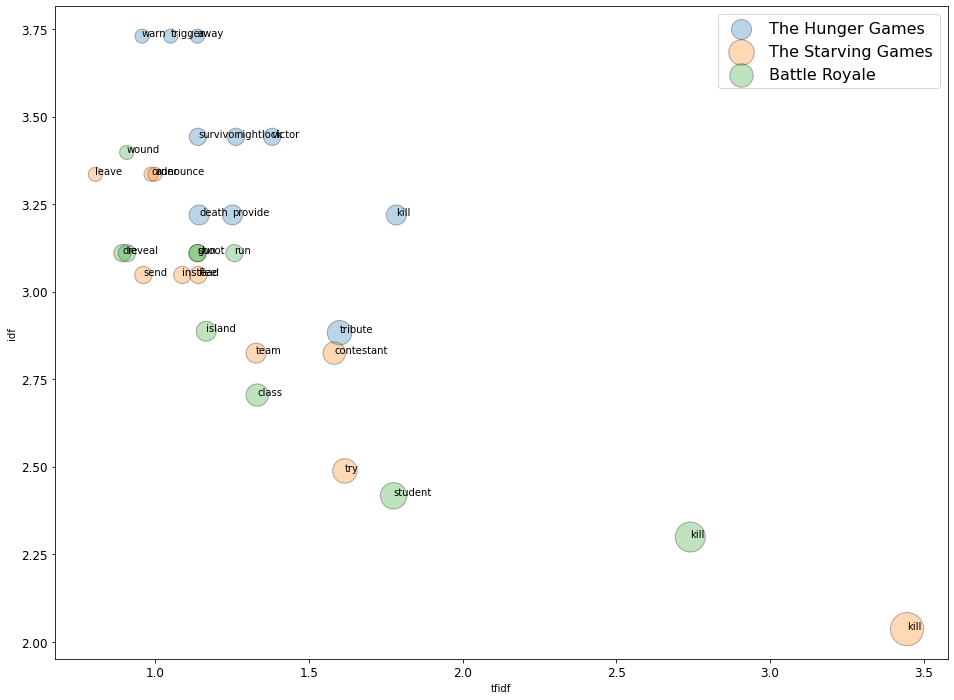

In [34]:
# Plotting the tf-idf distribution for the three movies
scatter_tfidf_10([HG, SG, BR], ['The Hunger Games', 'The Starving Games', 'Battle Royale'])

The most frequent words (higher weight in the documents) have indeed similar semantic meaning. 

## 4) Topic Models
Here I will be considering Asian countries separately as I would like to see how each country's plot differ based on topics but also which are the main topics narrated.

In [35]:
# Getting rid of too rare words and too frequent words (finding topic words per plot)
instances = data_clean['Plot_cleaned'].apply(str.split).tolist()  
phrases = Phrases(instances, min_count=3, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc) #create the term dictionary of the corpus (every unique term is assigned an index)
dictionary.filter_extremes(no_below=20, no_above=0.3) #deleting too common and too rare words

# Transform into TFIDF
#replace words by their numerical IDs and their frequency
ldacorpus = [dictionary.doc2bow(text) for text in instances] #convert corpus into document term matrix using dictionary instances

# learn TFIDF values from corpus
tfidfmodel = TfidfModel(ldacorpus)

# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

Since we are considering movies' plot spanning in almost 40 years among 7 countries, choosing topics that range from 5 to 16 should be acceptible. Due to the changes (in taste and events) occuring with time, and considering the grographical differences of the origins under consideration, there could be many topics arising from the plots. However, I will be focusing on the main ones.

In [36]:
# Choosing the number of topic models with Coherence scores
coherence_values = []
dev_size = 15000

for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], #see above
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -1.072962930897085 0.31859601586693787
6 -1.1278474343641165 0.3194189068163062
7 -1.0857928197389295 0.3231361698319504
8 -1.1573008602328487 0.3237836895585131
9 -1.048912312097724 0.3158389337337393
10 -1.1848603852212574 0.3249451755572151
11 -1.0682974613717262 0.34008552898752653
12 -1.2238613580540048 0.31545624413702916
13 -1.2610188070431438 0.32404078368713163
14 -1.1799657731510635 0.31948180270733434
15 -1.070897139923197 0.3293709235627053


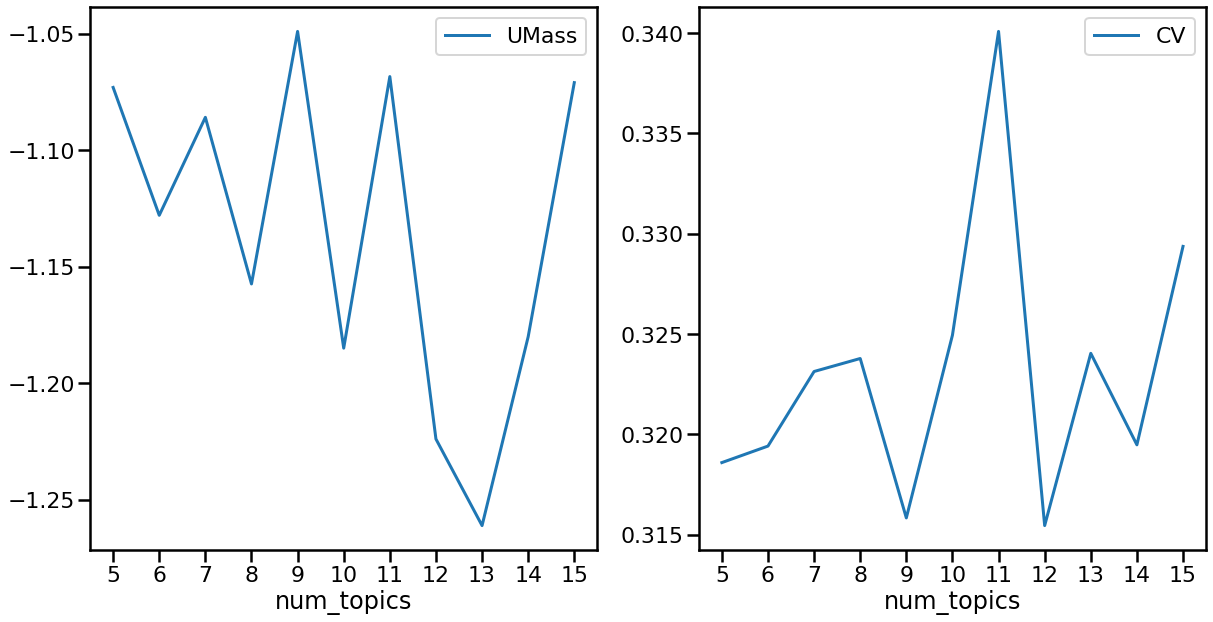

In [37]:
# Plotting it to choose the best number of topics
sns.set_context('poster') 

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));


In [38]:
# I am choosing 11 topics as from the UMAss and CV graphs, it is where both graphs are quite high 
# (whereas before CV values were small).

num_topics = 11

# Find chunksize to make about 100 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/100
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, 
                     alpha=0.5,
                     random_state=42)
    
print("done in {}".format(time.time()-start), flush=True)

1357.7
fitting model
done in 207.94438195228577


In [39]:
# LDA
Lda_object = gensim.models.ldamodel.LdaModel
lda_model_1 = Lda_object(ldacorpus, num_topics=num_topics, id2word = dictionary)

print(lda_model_1.print_topics(num_topics=num_topics, num_words=5))

[(0, '0.012*"mother" + 0.012*"school" + 0.010*"father" + 0.008*"child" + 0.007*"family"'), (1, '0.013*"film" + 0.006*"become" + 0.005*"life" + 0.005*"story" + 0.004*"make"'), (2, '0.016*"love" + 0.009*"friend" + 0.008*"marry" + 0.008*"father" + 0.007*"get"'), (3, '0.009*"murder" + 0.009*"house" + 0.007*"then" + 0.007*"death" + 0.006*"where"'), (4, '0.010*"police" + 0.007*"man" + 0.007*"get" + 0.006*"see" + 0.006*"then"'), (5, '0.009*"attack" + 0.007*"force" + 0.006*"escape" + 0.006*"soldier" + 0.006*"man"'), (6, '0.011*"house" + 0.009*"home" + 0.008*"friend" + 0.008*"come" + 0.007*"man"'), (7, '0.007*"money" + 0.007*"play" + 0.006*"work" + 0.005*"get" + 0.005*"team"'), (8, '0.007*"use" + 0.006*"return" + 0.006*"power" + 0.006*"then" + 0.006*"will"'), (9, '0.011*"fight" + 0.006*"make" + 0.006*"defeat" + 0.005*"time" + 0.005*"will"'), (10, '0.010*"escape" + 0.009*"then" + 0.009*"police" + 0.007*"reveal" + 0.007*"use"')]


In [40]:
topic_corpus = model[model_corpus]
model.print_topics()

[(0,
  '0.004*"village" + 0.004*"power" + 0.003*"defeat" + 0.003*"save" + 0.003*"fight" + 0.003*"battle" + 0.003*"evil" + 0.003*"spirit" + 0.003*"villager" + 0.003*"attack"'),
 (1,
  '0.013*"Will" + 0.013*"film" + 0.011*"story" + 0.010*"character" + 0.006*"comedy" + 0.006*"plot" + 0.006*"embark" + 0.005*"unlikely" + 0.005*"artist" + 0.004*"d"'),
 (2,
  '0.003*"love" + 0.003*"mother" + 0.003*"father" + 0.003*"family" + 0.003*"marry" + 0.002*"friend" + 0.002*"relationship" + 0.002*"house" + 0.002*"day" + 0.002*"girl"'),
 (3,
  '0.009*"serial" + 0.008*"drama" + 0.006*"dancer" + 0.006*"idol" + 0.005*"protagonist" + 0.005*"man" + 0.005*"brother" + 0.005*"nab" + 0.005*"son" + 0.005*"revenge"'),
 (4,
  '0.020*"role" + 0.019*"action" + 0.017*"film" + 0.011*"feature" + 0.011*"play" + 0.010*"support" + 0.007*"lead" + 0.007*"set" + 0.007*"story" + 0.006*"homeless"'),
 (5,
  '0.005*"respective" + 0.004*"mill" + 0.004*"farmer" + 0.004*"dream" + 0.004*"inspector" + 0.004*"girl" + 0.004*"big" + 0.003

In [41]:
# Get the topic descriptions and getting rid of useless formatting
topic_sep = re.compile("0\.[0-9]{3}\*") 
# Extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "village", "power", "defeat", "save", "fight"
2 "Will", "film", "story", "character", "comedy"
3 "love", "mother", "father", "family", "marry"
4 "serial", "drama", "dancer", "idol", "protagonist"
5 "role", "action", "film", "feature", "play"
6 "respective", "mill", "farmer", "dream", "inspector"
7 "ship", "alien", "destroy", "mission", "crew"
8 "team", "game", "win", "school", "student"
9 "police", "murder", "shoot", "gang", "drug"
10 "zombie", "sunny", "con", "portray", "dad"
11 "prison", "brother", "story", "murder", "sentence"


## 4.1) Visualisation: Topic Models

In [42]:
# Aggregating topics by their respective country 
target_category = 'Origin'

# transform the data into topic distributions
topic_corpus = model[model_corpus]

# get a list with the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(data_clean))]

# turn that into a dataframe with N rows and K columns, each with the score of the corresponding topic
topic_distr = pd.DataFrame(data=scores, columns=descriptors)

# add the review category of each document as column (so we can aggregate)
topic_distr['category'] = data_clean[target_category]

topic_distr.head()

,"village, power","Will, film","love, mother","serial, drama","role, action","respective, mill","ship, alien","team, game","police, murder","zombie, sunny","prison, brother",category
0,0.053877,0.038542,0.222118,0.038642,0.038665,0.039739,0.344756,0.067279,0.076968,0.039270,0.040146,American
1,0.185981,0.060174,0.066103,0.061024,0.063577,0.061709,0.156602,0.059764,0.063075,0.159078,0.062912,American
2,0.242808,0.043973,0.188689,0.042646,0.041667,0.050449,0.135961,0.051304,0.114902,0.041771,0.045829,American
3,0.128899,0.033689,0.251885,0.033980,0.033939,0.048029,0.275830,0.036469,0.089041,0.033927,0.034314,American
4,0.043155,0.035947,0.425658,0.035657,0.036784,0.057293,0.042283,0.038331,0.201926,0.039486,0.043480,American


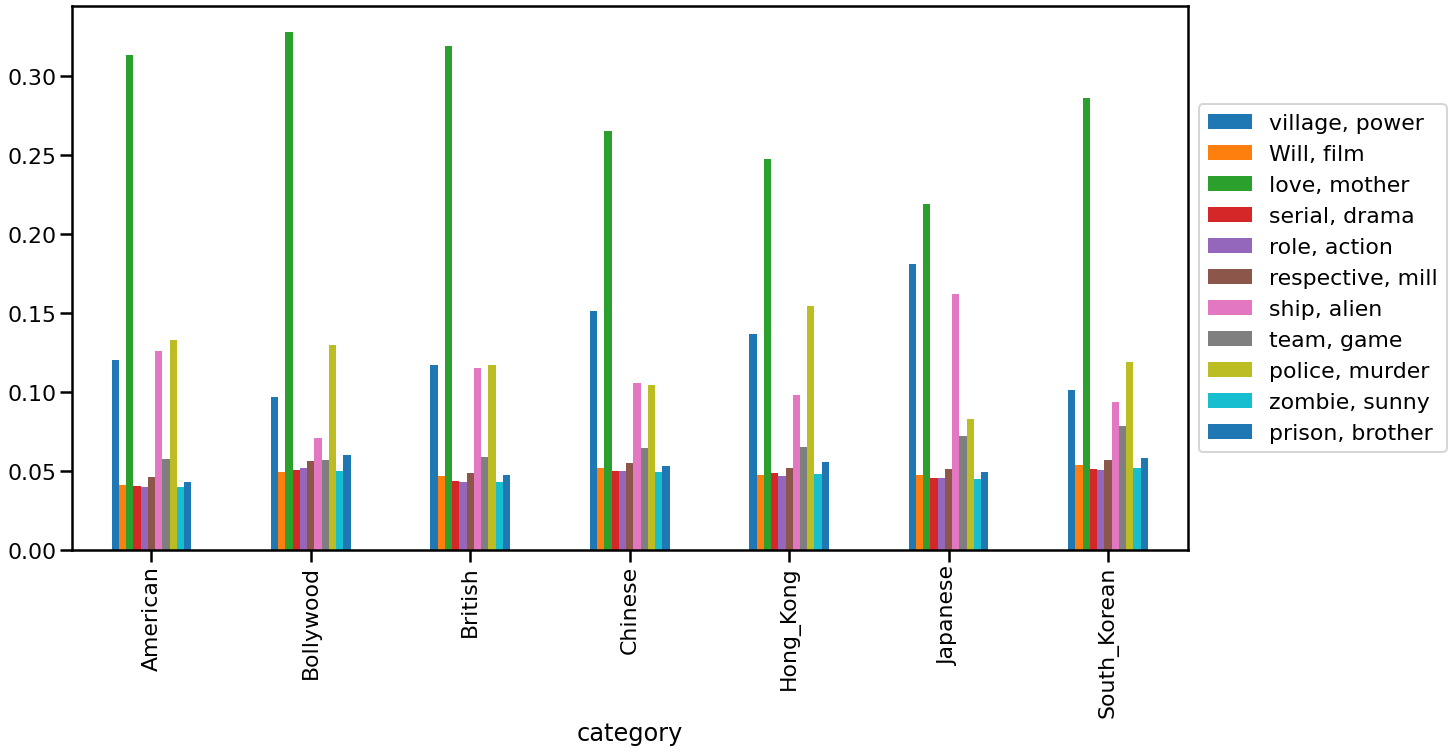

In [43]:
# Plotting the topic distributions per country
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(20, 10)) 

# aggregate topics by categories
aggregate_by_category = topic_distr[topic_distr.category.isin('American Hong_Kong Japanese Chinese South_Korean Bollywood British'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

From the graph it can be observed that the most common topic is love and family ("mother" here should be interpreted as "family" from its similarity with the other descriptors of its category). Japanese movies are the most keen on "alien" and "ship" (sci-fi) movies, which is actually quite popular overall, except on Bollywood when compared to other countries. Another common topic is "village, power", which is however more in vogue among Asian countries. 

## 5) Language Model
From the previous Topic Models, Bollywood movies' topics emerged as a somehow different from the other countries. So, here I will create language model for Bollywood movies and for American movies to see how both origins' plots might continue from a random sentence.

In [44]:
# I am interested in conditioning more words (the 5 previous words), 
# since I have a large corpus (to have more accurate relative frequencies)

smoothing = 0.0001
START = '_***_'
STOP = '_STOP_'
n_grams = 5  

random.seed(30)

In [45]:
# FOR USA PLOTS

# mapping the probability of a word given its history 
counts = defaultdict(lambda: defaultdict(lambda: smoothing))

# fitting the data on corpus
corpus_lm = [line.strip().split() for line in USA_df['Plot']] 
# I am not considering the cleaned Plot since I am studying ngrams and creating language models (I need sentence connectors)

letters = tuple([random.choice(string.ascii_letters) for i in range(n_grams)])

# collect counts for MLE
for sentence in corpus_lm:
    # include special tokens for start and the end of sentence
    tokens = [START for i in range(n_grams-1)] + sentence + [STOP]
    for letters in nltk.ngrams(tokens, n_grams):
        counts[tuple(letters[:-1])][letters[-1]] += 1
        

def sample_next_word(cond=tuple()): # to sample the next word from a given sentence
    
    keys, values = zip(*counts[cond].items()) # separate word and their counts into separate variables

    # normalize the counts into a probability distribution
    values = np.array(values)
    values /= values.sum() # create probability distribution
    
    sample = np.random.multinomial(1, values) # pick one position

    return keys[np.argmax(sample)]


def generate(initial=[],n_grams=4):
    result = [START for i in range(n_grams-1)] + initial
    for i in range((len(initial)+1)):
        try:
            next_word = sample_next_word(tuple([result[n-i] for n in range((-(n_grams-1)),0)]))
        except ValueError:
            pass
    
    result.append(next_word)
    
    c = n_grams

    while next_word != STOP:
        c -= 1
        if c-1 > 0:
            try:
                next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            except ValueError:
                next_word = sample_next_word(tuple([START for i in range(c-1)])+tuple([result[n] for n in range(-(n_grams-c),0)]))
            result.append(next_word)
        else:     
            next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            result.append(next_word)
    return ' '.join(result[n_grams-1:-1])

In [46]:
# FOR BOLLYWOOD PLOTS

# mapping the probability of a word given its history 
counts_bolly = defaultdict(lambda: defaultdict(lambda: smoothing))

# fitting the data on corpus
corpus_bolly = [line.strip().split() for line in Bollywood_df['Plot']] 
# I am not considering the cleaned Plot since I am studying ngrams and creating language models (I need sentence connectors)

letters_bolly = tuple([random.choice(string.ascii_letters) for i in range(n_grams)])

# collect counts for MLE
for sentence in corpus_bolly:
    # include special tokens for start and the end of sentence
    tokens = [START for i in range(n_grams-1)] + sentence + [STOP]
    for letters_bolly in nltk.ngrams(tokens, n_grams):
        counts_bolly[tuple(letters_bolly[:-1])][letters_bolly[-1]] += 1
        

def sample_next_word_bolly(cond=tuple()): # to sample the next word from a given sentence
    
    keys, values = zip(*counts_bolly[cond].items()) # separate word and their counts into separate variables

    # normalize the counts into a probability distribution
    values = np.array(values)
    values /= values.sum() # create probability distribution
    
    sample = np.random.multinomial(1, values) # pick one position

    return keys[np.argmax(sample)]


def generate_bolly(initial=[],n_grams=4):
    result = [START for i in range(n_grams-1)] + initial
    for i in range((len(initial)+1)):
        try:
            next_word = sample_next_word_bolly(tuple([result[n-i] for n in range((-(n_grams-1)),0)]))
        except ValueError:
            pass
    
    result.append(next_word)
    
    c = n_grams

    while next_word != STOP:
        c -= 1
        if c-1 > 0:
            try:
                next_word = sample_next_word_bolly(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            except ValueError:
                next_word = sample_next_word_bolly(tuple([START for i in range(c-1)])+tuple([result[n] for n in range(-(n_grams-c),0)]))
            result.append(next_word)
        else:     
            next_word = sample_next_word_bolly(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            result.append(next_word)
    return ' '.join(result[n_grams-1:-1])


In [73]:
# Generating a plot from a random phrase based on USA plots
usa_random_plot = generate('I like cakes. '.split(),n_grams)

# Generating a plot from a random phrase based on Bollywood plots
bolly_random_plot = generate_bolly('I like cakes. '.split(),n_grams)

In [74]:
# To see each random plot without constantly generating a new one:
print('RANDOM USA PLOT WITH LANGUAGE MODELS')
print(usa_random_plot)
print('\n')
print('RANDOM BOLLYWOOD PLOT WITH LANGUAGE MODELS')
print(bolly_random_plot )

RANDOM USA PLOT WITH LANGUAGE MODELS
I like cakes. In the last game of the season and Deuce questions his own ability to continue playing without his best friend. Deuce ends up playing and struggles right off the bat. But when Ed, Elizabeth and Lydia arrive at the game in time and return. Nick and Dalton arrive in Ambrose to find Carly and Wade. Nick visits the gas station, where Forrest hires dancer Maggie as a waitress. Shortly afterward, the gas station is closed, but she does not – that Roddy is, in fact, a ghost site made by one of Pratt's first victims, who is seeking revenge because people watched her being tortured and murdered. She was tortured by Pratt for 48 hours before she begged him to kill her, which he does by shooting them one by one. Lowe orders Pilot Lou (Boyd Banks) to dock in on Solaris, a nearby space station. As he is talking with the girls about her graduation night and losing her virginity ("Graduation Nite"), and later begins to vomit. Juanita is waiting in Jo

## 5.1) Visualisation: Language Models

In [75]:
#TF-IDF analysis (I am not using a word2vec since my documents (the random plots) are too small) 
bb = []
for i in (bolly_random_plot.split('.')): #preprocessing and deleting PROPN with .pos to keep only topic words
    bb.append(preprocess_tm(i))
    
b = tfidf_vect(bb) 

us = []
for j in (usa_random_plot.split('.')):
    us.append(preprocess_tm(j))

u = tfidf_vect(us)

#Showing only the ones with highest tfidf values
multi_table([u.tail(),b.tail() ])

,word,tf,idf,tfidf
48,play,2,2.673976,0.715151
9,carly,1,3.079442,0.755067
24,game,2,2.673976,0.780514
61,station,3,2.386294,0.868052
3,arrive,2,2.673976,1.119261
,word,tf,idf,tfidf
203,way,2,3.772589,1.156593
72,father,5,3.079442,1.226941
93,hotel,2,3.772589,1.241696
35,chair,3,3.484907,1.242545


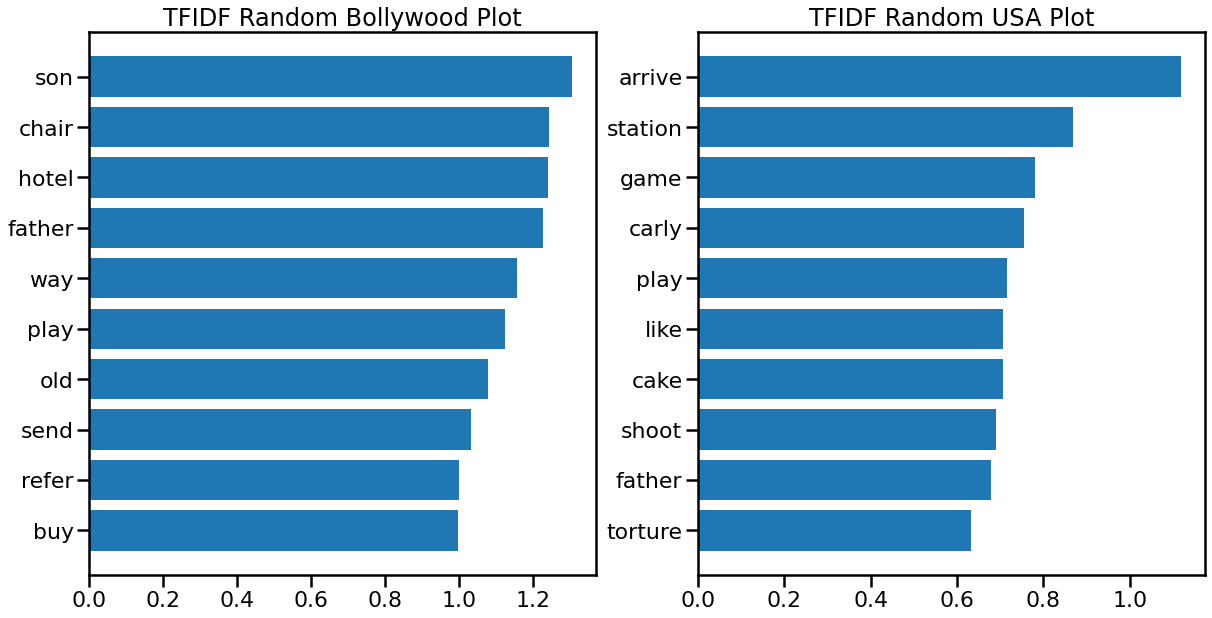

In [76]:
#Plot horizontally their tfidf distribution
new_u = u[['word', 'tfidf']].reset_index(drop= True) #plotting only based on the tfidf values
new_b = b[['word', 'tfidf']].reset_index(drop= True)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].set_title('TFIDF Random Bollywood Plot')
ax[0].barh(new_b['word'].tail(10), new_b['tfidf'].tail(10))
ax[1].set_title('TFIDF Random USA Plot')
ax[1].barh(new_u['word'].tail(10), new_u['tfidf'].tail(10))
plt.show()

Although the two documents were small, it is visible from the two graphs that Bollywood's plot tends to household themes, while the American one tends to action/battles topics.